**Importing libraries here**

In [1]:
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets

import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import random
from sklearn import preprocessing
%matplotlib inline

Different approach to loading the dataset

In [2]:
from google.colab import drive

#drive already mounted
drive.mount('/content/drive') 

DATA_PATH = "/content/drive/MyDrive/cs231n/assignments/assignment2/train_data.pkl"


with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)

X = data['X']
y = data['y']

# normalise
#X_norm = X - np.min(X, axis = 0, keepdims = True)
#X_norm = X_norm / (np.max(X_norm, axis = 0, keepdims = True) + 1e-6)

#new version
X_norm = preprocessing.normalize(X)

#split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, stratify = y, test_size = 0.9) 

Mounted at /content/drive


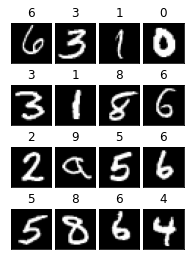

In [3]:
#displaying grid
for i in range(16):
  idx = random.randrange(0,60000,1)
  plt.subplot(4,4,i+1)
  image = np.reshape(X[idx], (28,28))
  drawing = plt.imshow(image, cmap = "gray")
  plt.title(y[idx][0])
  drawing.axes.get_xaxis().set_visible(False)
  drawing.axes.get_yaxis().set_visible(False)
plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.5, top = 0.9, wspace = 0.1, hspace = 0.4)
plt.show()

**Creating a Dataset Class**

In [4]:
# define your dataset class

class MNIST_Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, transform = False):
        'Initialization'
        #X for images, y for labels
        self.X = X
        self.y = y
        self.transform = transform

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.X[index]
        label = self.y[index]
        #X = self.transform(image)
        return image, label

train_dataset = MNIST_Dataset(X_train, y_train)
#test_dataset = MNIST_Dataset(X_test, y_test)

#print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
#print('The label for 50th image in train dataset: ',train_dataset[49][1])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle = True)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle = False)


#Idk why but as of now it is printing only of the following print statements :(

#batch of image tensor
#print(next(iter(train_loader))[0].size())

#batch of the corresponding labels
print(next(iter(train_loader))[1].size())


torch.Size([64, 1])


**nn.Module for your model**

Defining and Initializing The Neural Network

In [5]:
# define a child class of nn.Module for your model
# specify the architecture here itself

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #defining intermediate weights and biases 
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)

        self.fc4 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1) #inplace operator

#model = NeuralNetwork()

**Training**

In [6]:
#removed criterion from train paramters
def train(model, optimizer, train_loader, display_step=None):
  EPOCHS = 30
  for epoch in range(EPOCHS):
    for data in train_loader:
        X, y = data

        #to reshape the y to [64] from [64,1]
        y = torch.reshape(y, (-1,))

        #print(X.shape) : torch.Size([64, 1, 28, 28])
        
        #: torch.Size([64, 1, 28, 28])

        #removing stored value of previous grad from buffer
        model.zero_grad()

        #forward-prop step
        #print(X.view(-1, 28 * 28).shape) : torch.Size([64, 784])
        output = model(X.view(-1, 28 * 28).float())
        #print(output.shape) : torch.Size([64, 10])

        #assert output.shape == y.shape
        #negetive log likelihood loss
        loss = F.nll_loss(output, y)
        #loss = criterion(output, y)

        #back-prop step
        loss.backward()

        #update step
        optimizer.step()

    #training set loss
    print("Cost function after epoch ", epoch, "is :", loss.item())

#optimizer = optim.Adam(model.parameters(), lr=0.001)


**Initialize weights**

In [7]:
def init_weights():
  #On internet articles were saying pyTorch automatically initializes weights for us
  #and those work pretty well, so have postponed the self-initialisation for niow
  pass

**Prediction & Accuracy**

In [8]:
def predict(model, X_test):
  X_test_tensor = torch.from_numpy(X_test)
  #print(X_test_tensor.size())
  output = model(X_test_tensor.float())
  #output, inds = torch.max(output,dim=1) 
  return output

#predict(model, X_test)

In [22]:
def accuracy(pred, labels):
  #labels = torch.from_numpy(labels)
  correct = 0
  total = labels.size
  #output = model(data_input.view(-1, 784))
  for idx, i in enumerate(pred):
    if torch.argmax(i).item() == int(labels[idx]):
      correct += 1
  print('Accuracy: %f %%' % (100.0 * correct / float(total)))

#print(y_train.shape)

**Running the main loop**

In [25]:
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(model, optimizer, train_loader)
Y_pred = predict(model, X_test)
accuracy(Y_pred, y_test)

Cost function after epoch  0 is : 0.5939752459526062
Cost function after epoch  1 is : 0.3043893277645111
Cost function after epoch  2 is : 0.14999136328697205
Cost function after epoch  3 is : 0.10844426602125168
Cost function after epoch  4 is : 0.07393784075975418
Cost function after epoch  5 is : 0.059275757521390915
Cost function after epoch  6 is : 0.026441188529133797
Cost function after epoch  7 is : 0.011543355882167816
Cost function after epoch  8 is : 0.009164441376924515
Cost function after epoch  9 is : 0.01541982963681221
Cost function after epoch  10 is : 0.017533324658870697
Cost function after epoch  11 is : 0.0684811919927597
Cost function after epoch  12 is : 0.020339660346508026
Cost function after epoch  13 is : 0.009503056295216084
Cost function after epoch  14 is : 0.037956539541482925
Cost function after epoch  15 is : 0.016639040783047676
Cost function after epoch  16 is : 0.006047563627362251
Cost function after epoch  17 is : 0.04535253718495369
Cost function

Playing with The Model

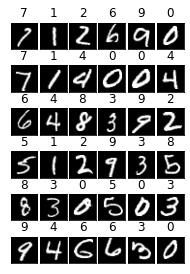

In [26]:
# print(type(X_test[1]))
# print(X_test[1].shape)
# plt.imshow(X_test[1].reshape([28,28]))
# plt.title("Test Image")
# plt.axis('off')
# plt.show()

def val(m, b):
  for idx, i in enumerate(b):
      if idx == m:
        return torch.argmax(i).item()

Y_pred = predict(model, X_test)
for i in range(36):
  idx = random.randrange(0,y_test.size,1)
  plt.subplot(6,6,i+1)
  image = X_test[idx].reshape([28,28])
  drawing = plt.imshow(image, cmap = "gray")
  plt.title(val(idx, Y_pred))
  drawing.axes.get_xaxis().set_visible(False)
  drawing.axes.get_yaxis().set_visible(False)
plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.5, top = 0.95, wspace = 0.1, hspace = 0.4)
plt.show()

Submission

To submit your solution, you will need to make a file with name model.py containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ass_2.pt. When you are done with the assignment, commit the updated notebook, the model.py class file and the ass_2.pt model-weights file to the repository.

In [12]:
from google.colab import files
torch.save(model, 'ass_2.pt')
files.download('ass_2.pt') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

***Code ends here! After that its just some different ideas I was trying***

**Loading and Transforming The Data** 

In [13]:
# train = datasets.MNIST("", train=True, download=True,
#                       transform = transforms.Compose([transforms.ToTensor()]))
# test = datasets.MNIST("", train=False, download=True,
#                       transform = transforms.Compose([transforms.ToTensor()]))
# #print("train : ", list(train.shape))
# #print("test : ", test.shape)
# print(type(train))
# print(len(train))
# print(len(test))

# trainset = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
# testset = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True)

# print(type(trainset))
# print(len(trainset))

# #print("trainset shape : ", list(train.shape))
# #print("testset shape : ", test.shape )

# #AttributeError: 'MNIST' object has no attribute 'shape'

**Validating The Training**

In [14]:
# print(model.parameters())

In [15]:
# parameters = train(X_train, y_train, 128)
# Ypred = predict(X_train, parameters)

# print("Train cases", end = " ")
# accuracy(Ypred, y_train)
# print()

# Ypred = predict(X_test, parameters)
# #This piece was wriiten to just get the feel of how and what my neural network is 
# #predicting.

# for i in range(36):
#   idx = random.randrange(0,y_test.size,1)
#   plt.subplot(6,6,i+1)
#   image = np.reshape(X_test[idx], (28,28))
#   drawing = plt.imshow(image, cmap = "gray")
#   plt.title(Ypred[idx][0])
#   drawing.axes.get_xaxis().set_visible(False)
#   drawing.axes.get_yaxis().set_visible(False)
# plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.5, top = 0.9, wspace = 0.1, hspace = 0.4)
# plt.show()

# accuracy(Ypred, y_test)

In [16]:
# # With Learnable Parameters
# m = nn.BatchNorm1d(100)
# # Without Learnable Parameters
# m = nn.BatchNorm1d(100, affine=False)
# input = torch.randn(20, 100)
# print(input, "\n")
# output = m(input)
# print(output)

Check if it got saved right!

In [17]:
# load the model, use predict function

In [18]:
# a = torch.tensor([1,2,3])
# print(a.shape)
# print(y_test.size)